# Follow these instructions:

Once you are finished, ensure to complete the following steps.

1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline.

## Assignment Week 8: Text Mining using Dimensionality Reduction Methods [_/100 Marks]

This dataset comes from the #TidyTuesday repository and represents 2122 TV shows. In this assignment, we will apply dimensionality reduction methods to improve our understanding of text data and to predict the number of seasons of the TV shows. 

In [1]:
import numpy as np
import pandas as pd
import umap
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA, TruncatedSVD
import sklearn.feature_extraction.text as sktext
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from itertools import product

import seaborn as sns
import matplotlib.pyplot as plt
seed = 0

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yasin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Task 1: Decomposition of the texts [ /66 marks]

### Question 1.1

The dataset comes with the a few text variables and a categorical variable which represents whether a TV show has one season or more than one season. Import the data and create a new variable called 'full_description' by combining the three columns title, listed_in, and description. Keep the two columns,'duration' and 'full_description', and remove the rest. Do binary encoding for the traget variable 'duration'. Assign 1 to 'More than one season' and 0 to 'One season'. In the "full_description" column replace the word "Sci-Fi" with the word "Sci_Fi" since we would want to treat "Sci-Fi" as single word. Select the full_description column and display its first 10 rows. Use sklearn's `TfidfVectorizer` to eliminate accents, special characters, and stopwords (please see below to find out what stopwords need to be removed). In addition, make sure to eliminate words that appear in less than 5% of documents and those that appear in over 95%. You can also set `sublinear_tf` to `True`. After that, split the data into train and test with `test_size = 0.2` and `seed = seed`. Calculate the [Tf-Idf transform](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) for both train and test. Note that you need to fit and transform the inputs for the train set but you only need to transform the inputs for the test set. Don't forget to turn the sparse matrices to dense ones after you apply the `Tf-Idf` transform.  

In [2]:
# Load the data [ /1 mark]
netflix_data = pd.read_csv('Netflix_data.csv')

# Create a new variable called 'full_description' by combining the three columns title, listed_in, and description [ /2 marks]
# use an empty space to concat these three columns
netflix_data['full_description'] = netflix_data['title'].astype(str) +" "+ netflix_data['listed_in'].astype(str) +" "+ netflix_data['description'].astype(str)

# Keep two columns,'duration' and 'full_description', and remove the rest
netflix_data = netflix_data[['duration', 'full_description']]

# Do binary encoding for the traget variable 'duration'. Assign 1 to 'More than one season' and 0 to 'One season' [ \1 mark]
netflix_data['duration'] = netflix_data['duration'].apply(lambda x: 1 if x == 'More than one season' else 0)

# In the "full_description" column replace the word "Sci-Fi" with the word "Sci_Fi" [ \1 mark]
netflix_data['full_description'].replace('Sci-Fi', 'Sci_Fi', inplace = True, regex = True)
# Select the following column and display its first 10 rows: full_description [ /1 mark]
print(netflix_data['full_description'].head(10))

0    3% International TV Shows, TV Dramas, TV Sci_F...
1    46 International TV Shows, TV Dramas, TV Myste...
2    1983 Crime TV Shows, International TV Shows, T...
3    1994 Crime TV Shows, Docuseries, International...
4    ​SAINT SEIYA: Knights of the Zodiac Anime Seri...
5    (Un)Well Reality TV This docuseries takes a de...
6    #blackAF TV Comedies Kenya Barris and his fami...
7    Şubat Crime TV Shows, International TV Shows, ...
8    100 Days My Prince International TV Shows, Rom...
9    100 Humans Docuseries, Science & Nature TV One...
Name: full_description, dtype: object


In [3]:
# Defining the TfIDFTransformer [ /4 marks]
# Define a vectors of stop words: stop words list must contain 'english' stop words, 'shows', and 'tv' 
my_stop_words = ['shows', 'tv'] + list(stopwords.words('english'))
TfIDFTransformer = sktext.TfidfVectorizer(strip_accents = 'unicode', # Eliminate accents and special characters
                      stop_words = my_stop_words, # Eliminates stop words
                      min_df = 0.05, # Eliminate words that do not appear in more than 5% of texts
                      max_df = 0.95, # Eliminate words that appear in more than 95% of texts
                      sublinear_tf = True # Use sublinear weights (softplus)
                      )


# Train/test split [ /2 marks]
x_train, x_test, y_train, y_test = train_test_split(netflix_data['full_description'],
                                                    netflix_data['duration'],
                                                    test_size = 0.2,
                                                    random_state = seed)

# Calculate the Tf-Idf transform [ /2 marks]
TfIDF_train = TfIDFTransformer.fit_transform(x_train)
TfIDF_test = TfIDFTransformer.transform(x_test)

From here on, you will use the variables `TfIDF_train` and `TfIDF_test` as the input for the different tasks, and the `y_train` and `y_test` labels for each dataset (if required). Print the number of indices in the ouput using [`TfIDFTransformer.get_feature_names()` method](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html).

In [4]:
# Print the number of indices [ /2 marks]
print('There are %i words in the index.' % len(TfIDFTransformer.get_feature_names_out()))

There are 25 words in the index.


### Question 1.2
Now we have the TfIDF matrix so we can start working on the data. We hope to explore what some commonly occuring concepts are in the 'full_description' column. We can do this using PCA. A PCA transform of the TF-IDF matrix will give us a basis of the text data, each component representing a *concept* or set of words that are correlated. Correlation in text can be interpreted as a relation to a similar topic. Calculate a PCA transform of the training data using the **maximum** number of concepts possible. Make a plot of the explained variance that shows the cumulative explained variance per number of concepts.

Text(0, 0.5, 'Explained variance %')

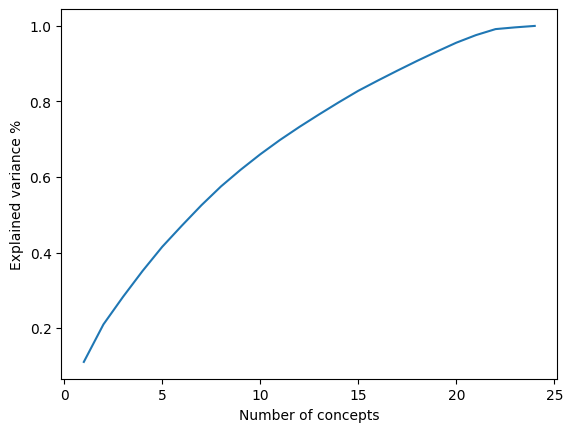

In [5]:
# Apply PCA on training data and get the explained variance [ / 4 marks]
PCA_description = PCA(n_components = 24)
PCA_description.fit(csr_matrix(TfIDF_train).toarray())
PCA_variances = PCA_description.explained_variance_ratio_


# Plotting explained variance with number of concepts [ / 4 marks]
plt.plot(np.arange(1, 25), np.cumsum(PCA_variances))
plt.xlabel('Number of concepts')
plt.ylabel('Explained variance %')

**Question:** Exactly how many concepts do we need to correctly explain at least 80% of the data?


In [20]:
# To get the exact index where the variance is above 80% [ / 4 marks]
index80 = next(x for x, val in enumerate(np.cumsum(PCA_variances)) if val >= 0.8) + 1
print(index80)

15


**Your Answer:** We need 15 concepts in order to explain at least 80% of the variance.

### Question 1.3

Let's examine the first three concepts by looking how many variance they explained and showing the 10 words that are the most important in each of these three concepts (as revealed by the absolute value of the PCA weight in each concept).


In [7]:
# Explained variance [ / 2 marks]
print('The first three components explain %.2f%% of the variance.' % (np.cumsum(PCA_variances)[2] * 100))

The first three components explain 28.28% of the variance.


In [8]:
# Get 10 most important words for each component [ / 4 marks]
words_per_row = TfIDFTransformer.get_feature_names_out()
most_important = [np.argpartition(np.abs(PCA_description.components_[i]), -10)[-10:] for i in range(3)]

In [9]:
# Words for concept 1 [ / 2 marks]
[words_per_row[i] for i in most_important[0]]

['british',
 'docuseries',
 'reality',
 'romantic',
 'comedies',
 'series',
 'kids',
 'international',
 'dramas',
 'crime']

In [10]:
# Words for concept 2 [ / 2 marks]
[words_per_row[i] for i in most_important[1]]

['friends',
 'series',
 'dramas',
 'romantic',
 'reality',
 'british',
 'crime',
 'comedies',
 'docuseries',
 'kids']

In [11]:
# Words for concept 3 [ / 2 marks]
[words_per_row[i] for i in most_important[2]]

['korean',
 'kids',
 'reality',
 'romantic',
 'love',
 'dramas',
 'docuseries',
 'crime',
 'comedies',
 'international']

### Question 1.4

 Apply the PCA transformation to the test dataset. Use only the first two components and make a scatter plot of the TV shows. Identify the 'More than one season' TV shows, and 'One season' TV shows by colouring points with different colours. Make sure to add a legend to your plot!

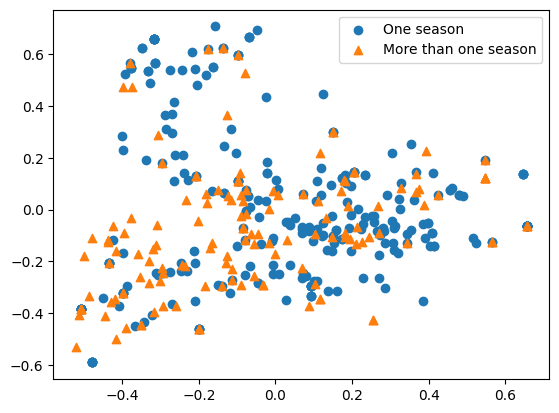

In [12]:
# Apply PCA to the test dataset [ / 2 marks]
test_pca = PCA_description.transform(csr_matrix(TfIDF_test).toarray())


# Plot the two different set of points with different markers and labels [ /4 marks]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(test_pca[:, 0][y_test == 0], test_pca[:, 1][y_test == 0], marker = 'o', label = 'One season')
ax.scatter(test_pca[:, 0][y_test == 1], test_pca[:, 1][y_test == 1], marker = '^', label = 'More than one season')
plt.legend()

**Question:** What can we say about where 'More than one season' TV shows and 'One season' TV shows lie in our plot? Could we use these concepts to discriminate these cases? If yes, why? If no, why not? Discuss your findings. [ /2 marks]
 
**Your answer:** 'More than one season' TV shows are mostly located in the lower part of the plot, while 'One season' TV shows are mostly scattered in the middle and top-left corner. We cannot use the first two components to discriminate 'More than one season' TV shows and 'One season' TV shows since there exists overlap for both groups.

### Question  1.5

Repeat the process above, only now using a UMAP projection with two components. Test all combinations of ```n_neighbors=[2, 10, 25, 35, 45]``` and ```min_dist=[0.1, 0.25, 0.5, 1]``` over the train data and choose the projection that you think is best, and apply it over the test data. Use 1000 epochs, a cosine metric and random initialization. If you have more than 8GB of RAM (as in Colab), you may want to set ```low_memory=False``` to speed up computations.

*Hint: [This link](https://stackoverflow.com/questions/16384109/iterate-over-all-combinations-of-values-in-multiple-lists-in-python) may be helpful.*



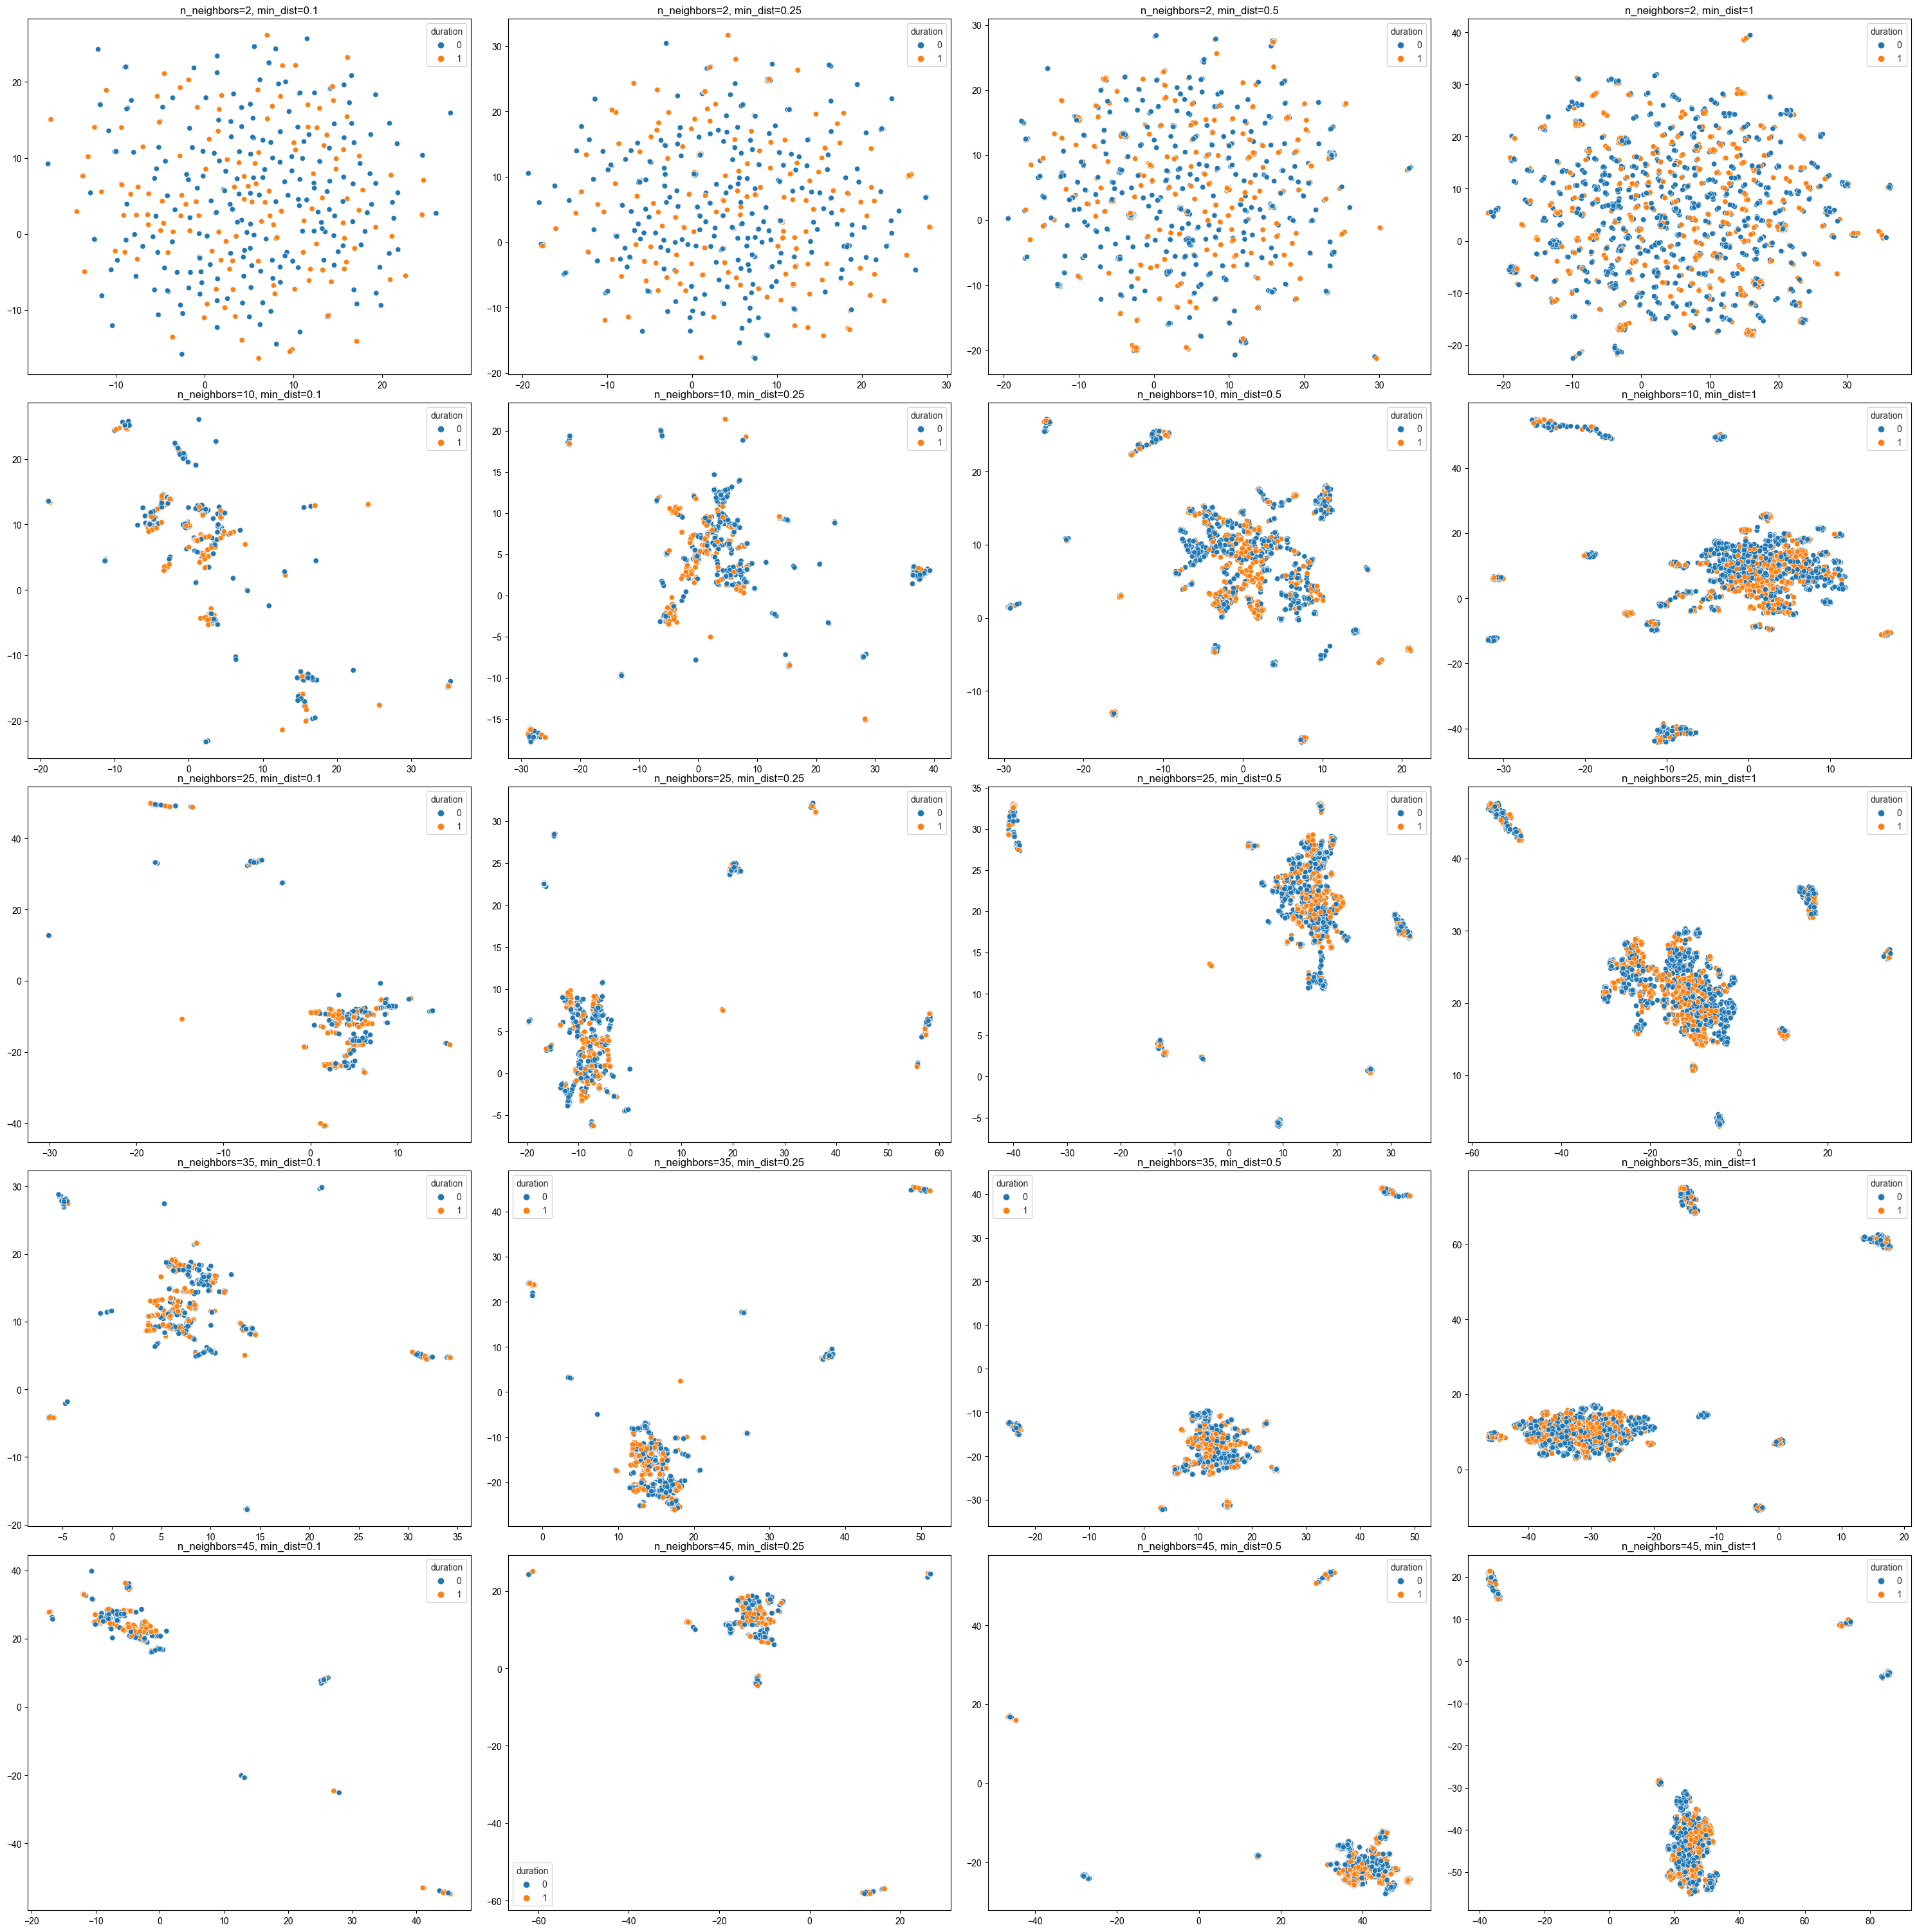

In [13]:
# Set parameters
fig, axs = plt.subplots(5, 4, figsize=(30,30))
n_neighbors=[2, 10, 25, 35, 45]
min_dist=[0.1, 0.25, 0.5, 1]
fig.tight_layout()
sns.set_style('white')

# Create UMAP and plots [ / 8 marks]
for (i,j), (nei, dist) in zip(product([0,1,2,3,4],[0,1,2,3]), product(n_neighbors, min_dist)):
    UMAP_description = umap.UMAP(n_components = 2,
                             metric='cosine',
                             n_epochs=1000,
                             low_memory=False,
                             n_neighbors=nei,
                             spread=1,
                             min_dist=dist,
                             init='random'
                            )

    x_train_umap = UMAP_description.fit_transform(TfIDF_train)

    # Create plot
    sns.scatterplot(x=x_train_umap[:, 0], y=x_train_umap[:, 1], hue=y_train, ax=axs[i,j])
    axs[i,j].title.set_text(f"n_neighbors={nei}, min_dist={dist}")

plt.show()



**Question:** Which paramter would you choose? [ / 2 makrs]

**Your Answer:** We can see that 2 neighbours is too little. Using higher neighbours result in better embedding. Regarding min_dist, 0.5 has the best structure (for me at least, they can argue differently and it should be considered correct).

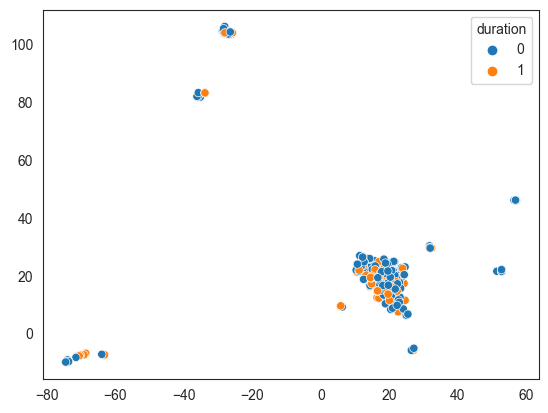

In [14]:
# Choose the paramters that you think are best and apply to test set [ / 4 marks]
UMAP_description = umap.UMAP(n_components = 2,
                          metric='cosine',
                          n_epochs=5000,
                          low_memory=False,
                          n_neighbors=25,
                          min_dist=0.5,
                          init='random'
                        )

x_train_umap = UMAP_description.fit_transform(TfIDF_train)
x_test_umap = UMAP_description.transform(TfIDF_test)

# Create plot [ /2 marks]
sns.scatterplot(x=x_test_umap[:, 0], y=x_test_umap[:, 1], hue=y_test)
plt.show()


**Question:** How does the plot compare to the PCA one? [ /2 marks]

**Your answer:** The new plot looks fairly different than the PCA one. Still, there is no easy way of separating the two groups.

## Task 2: Benchmarking predictive capabilities of the compressed data [ / 34 marks]

For this task, we will benchmark the predictive capabilities of the compressed data against the original one. 



### Question 2.1 
Train a regularized logistic regression over the original TfIDF train set using l2 regularization. Calculate the AUC score and plot the ROC curve for the original test set.

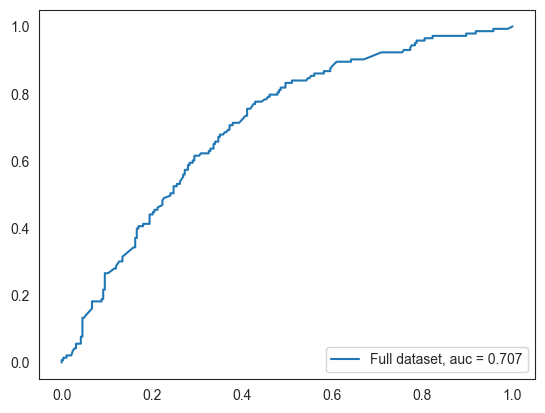

In [15]:
# Train and test using model LogisticRegressionCV [ /3 marks]

# Define the model
LogRegFull = LogisticRegressionCV(Cs = 10,
                                  cv = 3,
                                  penalty = 'l2',
                                  solver = 'lbfgs',
                                  tol = 0.0001,
                                  max_iter = 1000,
                                  n_jobs = -1,
                                  refit = True,
                                  random_state = seed
                                 )

# Fit on the training dataset
LogRegFull.fit(TfIDF_train, y_train)

# Apply to the test dataset
probs_test_full = LogRegFull.predict_proba(TfIDF_test)



# Plot ROC curve and compute AUC score [ /2 marks]
# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, probs_test_full[:, 1])

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = y_test, 
                             y_score = probs_test_full[:, 1]), decimals = 3)

# Create and show the plot
plt.plot(fpr, tpr, label = "Full dataset, auc = " + str(auc))
plt.legend(loc = 4)
plt.show()

### Question 2.2 
Train a regularized logistic regression over an SVD-reduced dataset (with 13 components) using l2 regularization. Calculate the AUC score and plot the ROC curve for the SVD-transformed test set.

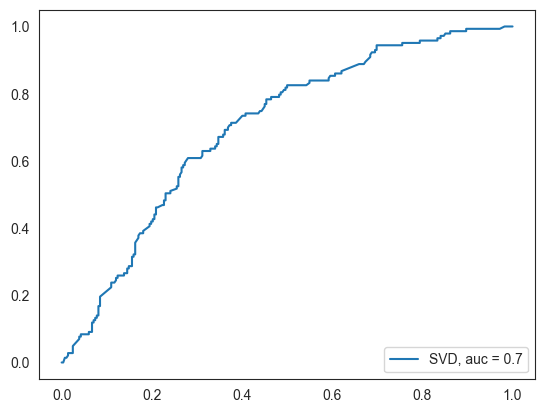

In [16]:
# Apply SVD first [ / 4 marks]
SVD_description = TruncatedSVD(n_components = 13,
                           n_iter=10,
                           random_state=42
                           )
x_train_pca = SVD_description.fit_transform(TfIDF_train)
x_test_pca = SVD_description.transform(TfIDF_test)

#Train and test using model LogisticRegressionCV [ /3 marks]
LogRegSVD = LogisticRegressionCV(Cs = 10,
                                 cv = 3,
                                 penalty = 'l2',
                                 solver = 'lbfgs',
                                 tol = 0.0001,
                                 max_iter = 1000,
                                 n_jobs = -1,
                                 refit = True,
                                 random_state = 123456789
                                 )


LogRegSVD.fit(x_train_pca, y_train)
probs_test_svd = LogRegSVD.predict_proba(x_test_pca)


# Plot ROC curve and compute AUC score [ /2 marks]
# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, probs_test_svd[:, 1])

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = y_test, 
                             y_score = probs_test_svd[:, 1]), decimals = 3)

# Create and show the plot
plt.plot(fpr, tpr, label = "SVD, auc = " + str(auc))
plt.legend(loc = 4)
plt.show()


### Question 2.3 
Train a regularized logistic regression over the UMAP-reduced dataset (with 13 components using the same parameters as Task 1.5) using l2 regularization. Calculate the AUC score and plot the ROC curve for the UMAP-transformed test set.

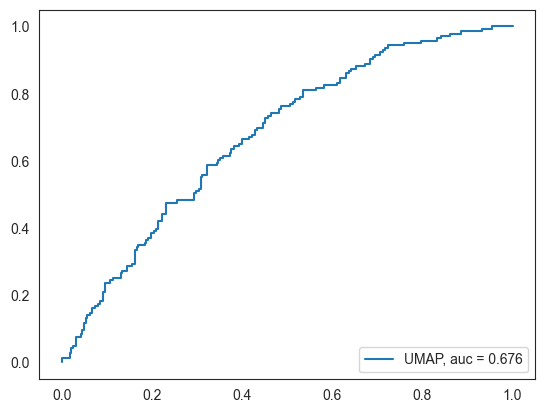

In [17]:
# Apply UMAP first [ / 3 marks]
UMAP_description = umap.UMAP(n_components = 13,
                          metric='cosine',
                          n_epochs=5000,
                          low_memory=False,
                          n_neighbors=25,
                          min_dist=0.5,
                          init='random'
                        )
x_train_umap = UMAP_description.fit_transform(TfIDF_train)
x_test_umap = UMAP_description.transform(TfIDF_test)

#Train and test using model LogisticRegressionCV [ /4 marks]
LogRegUMAP = LogisticRegressionCV(Cs = 10,
                                  cv = 3,
                                  penalty = 'l2',
                                  solver = 'lbfgs',
                                  tol = 0.0001,
                                  max_iter = 1000,
                                  n_jobs = -1,
                                  refit = True,
                                  random_state = 123456789
                                  )


LogRegUMAP.fit(x_train_umap, y_train)
probs_test_umap = LogRegUMAP.predict_proba(x_test_umap)


# Plot ROC curve and compute AUC score [ /2 marks]
# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, probs_test_umap[:, 1])

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = y_test, 
                             y_score = probs_test_umap[:, 1]), decimals = 3)

# Create and show the plot
plt.plot(fpr, tpr, label = "UMAP, auc = " + str(auc))
plt.legend(loc = 4)
plt.show()

### Question 2.4
Train a XGBoost model over the SVD-reduced dataset prepared in Question 2.2. Calculate the AUC score and plot the ROC curve for the SVD-transformed test set. In your model set ``num_boost_round=10`` and ``early_stopping_rounds=2``. You need to do CV using the training dataset, and then get best iteration based on cross-validation results. Finally, train the model on full training dataset with best number of iterations.

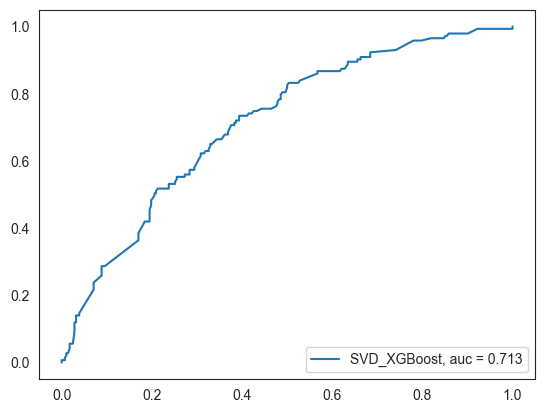

In [18]:
# Define XGBoost parameters
params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "max_depth": 3,
}

# Define cross-validation object
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Perform cross-validation with XGBoost [ \3 marks]
cv_results = xgb.cv(
    params=params,
    dtrain=xgb.DMatrix(x_train_pca, label=y_train),
    num_boost_round=10,
    folds=cv,
    metrics=["auc"],
    early_stopping_rounds=2,
    seed=42
)

# Get best iteration based on cross-validation results [\ 1 mark]
best_iteration = cv_results["test-auc-mean"].argmax()

# Train final model on full dataset with best number of iterations [\ 2 mark]
model = xgb.train(
    params=params,
    dtrain=xgb.DMatrix(x_train_pca, label=y_train),
    num_boost_round=best_iteration+1
)

# Compute predicted probabilities on the test set [\ 1 mark]
dtest = xgb.DMatrix(x_test_pca)
y_prob_test = model.predict(dtest)

# Plot ROC curve and compute AUC score [ /2 marks]
# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = y_test, 
                             y_score = y_prob_test), decimals = 3)

# Create and show the plot
plt.plot(fpr, tpr, label = "SVD_XGBoost, auc = " + str(auc))
plt.legend(loc = 4)
plt.show()

### Question 2.5
Compare the performance of the four models. Which one is the best. [ / 2 marks] 

**Your Answer:** It can be seen that the XGBoost model trained over the SVD-reduced dataset performs better than others. One may decide to train the XGBoost model on the original training dataset or UMAP-reduced dataset.